# Brex Data Challenge

## Abstract

**Task: Calculate the approximate total daily balance per customer**

Because of the complexity of the task, I use python to do data manipulation and calculation.

According to **customer_accounts** and **financial_accounts** tables, we find one individual customer probably have multiple financial accounts. Thus the first step is to compute the sum of each customer's balance & transaction amount by using `group_by`.


According to both **financials_balances** and **financials_transactions** tables, we find some balance amout are missing in a specific datetime range. However, some of them can be computed by the information of financials_transactions table. That is:

- *Balance(t) + Transaction(t) = Balance(t+1)*

- *Balance(t) - Transaction(t-1) = Balance(t-1)*

Thus the second step is to get these computable balance amount by shifting by 1 day. **Note that** the recursive function probably run multiple times, so here I set a loop for the shifting calculation until there is no more new balance amount gained.

Finanlly, I apply the method over all **customer_accounts** and construct the target DataFrame.

Pleach check my code for more information, some explainations are included in comments.

## Initialization

In [1]:
# Check python version
# -*- coding: utf-8 -*-

import sys
sys.version

'3.6.3 |Anaconda custom (64-bit)| (default, Oct 15 2017, 03:27:45) [MSC v.1900 64 bit (AMD64)]'

In [2]:
from collections import Iterable

import numpy as np
import pandas as pd
from tqdm import tqdm

tqdm.pandas()

%matplotlib inline

In [3]:
# Make sure all csv files are in the same work path

CustomerAccounts = pd.read_csv("./customer_accounts.csv")
FinancialAccounts = pd.read_csv("./financials_accounts.csv")
FinancialBalances = pd.read_csv("./financials_balances.csv")
FinancialTransactions = pd.read_csv("./financials_transactions.csv")

## Quick check of all tables

In [4]:
CustomerAccounts.head()

,id,name
0,aacc_c10cwqghq00001owfyvwq126,Customer account 1
1,aacc_c8lodc9z00001pjfyvwq126,Customer account 2
2,aacc_czj999vto000j1mo1qkb1ydg,Customer account 3
3,aacc_celx54f0r000a1qqh4lnefn9,Customer account 4
4,aacc_cnq7b2pys000a1t4h4lnefn9,Customer account 5


In [5]:
FinancialAccounts.head()

,id,customer_account_id,name
0,finacc_ctzrz94k00051v354687jg1,aacc_c10cwqghq00001owfyvwq126,Bank account 1
1,finacc_ctzrz8vz00031v3wyouo0dk,aacc_c10cwqghq00001owfyvwq126,Bank account 2
2,finacc_ctzrz91d00041v3h6cklh2s,aacc_c10cwqghq00001owfyvwq126,Bank account 3
3,finacc_ctzrz98x00071v3k3hz7qls,aacc_c10cwqghq00001owfyvwq126,Bank account 4
4,finacc_ctzrz9aw00081v3ghgxf64s,aacc_c10cwqghq00001owfyvwq126,Bank account 5


In [6]:
FinancialBalances.head()

,id,account_id,amount,accrual_date
0,finblce_clqsroena000b1o70b5d0240d,finacc_clqsrob7p000a1o70h4lnefn9,20000000,2018-03-27
1,finblce_clr5aflhj008l1o70d0i79s1u,finacc_clr5afi01008k1o703vlrv3it,666181756,2017-10-13
2,finblce_clt7z6u9500b41o70np8qcjsr,finacc_clr5afi01008k1o703vlrv3it,414855384,2018-03-28
3,finblce_clv20f0yn00lu1o70kn9jksah,finacc_clqsrob7p000a1o70h4lnefn9,20000000,2018-03-28
4,finblce_csb6sn3tc0003e5a8wyouo0dk,finacc_csb6smrli0002e5a8b7haliai,12571741,2018-03-30


In [7]:
FinancialTransactions.head()

,id,account_id,amount,accrual_date
0,fintrn_clqswgddo000d1o70bw046m1l,finacc_clqsrmqo800081o70ghgxf64s,-1142,2017-10-04
1,fintrn_clqswgdgq000e1o707aru17jl,finacc_clqsrmqo800081o70ghgxf64s,-1800,2017-10-02
2,fintrn_clqsz0mzq000i1o700nzc0xi4,finacc_clqsrob7p000a1o70h4lnefn9,1043933,2018-03-26
3,fintrn_clqsz0n1b000j1o701qkb1ydg,finacc_clqsrob7p000a1o70h4lnefn9,-1200,2018-03-26
4,fintrn_clqsz0n2z000k1o70zkcqk7ti,finacc_clqsrob7p000a1o70h4lnefn9,-986752,2018-03-26


### Some Findings and Decisions
- These 4 tables are obviously related by the `id` columns, 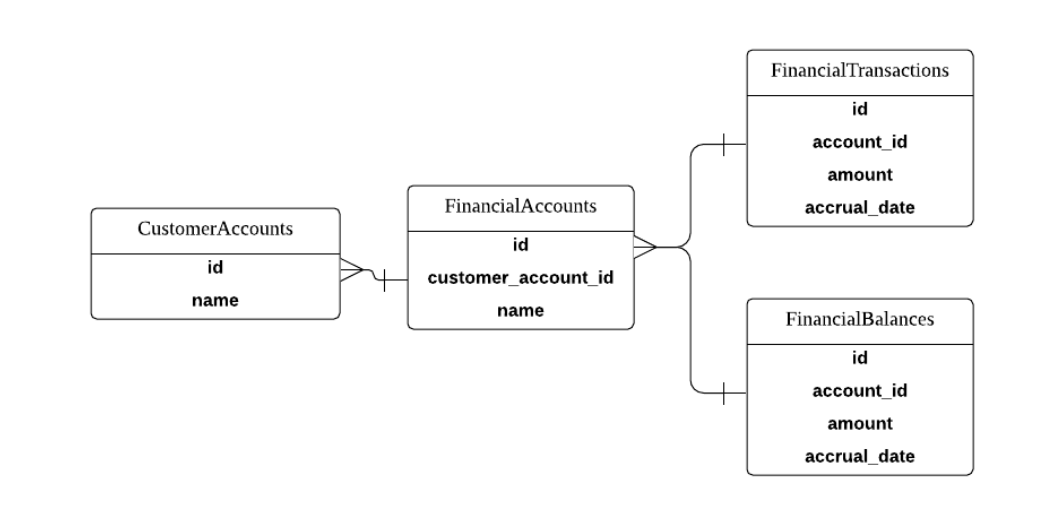
- Check the `CustomerAccounts.id` & `FinancialAccounts.customer_account_id`, there is an non-corresponding issue, I will use the union set of both as the total customers to output.
- Some accounts' `FinancialBalance.amount` & `FinancialTransctions.amount` are not correctly computed, I will assume the `FinancialBalance.amount` is always correct when conflicting with `FinancialTransctions.amount`.
- Due to the date range is required for 2017-01-01 to 2018-09-22, I will fill NA(where customers' balance can't be calculated by related balance and transactions) with the newest date's balance. 
- For some customers who appear in `CustomerAccounts` while don't have any Financial Account, I will leave their daily balance as 0.

## Define Generic Function

In [8]:
def calculate_balance(account_id: str, start_date: str = "2017-01-01", end_date: str = "2018-09-22") -> np.ndarray:
    
    """
    This function is to do multiple table join and manipulation to get the daily balance for single `account_id` from `start_date` 
    to `end_date`.
    
    Note: Before running this function, make sure `CustomerAccounts`, `FinancialAccounts`, `FinancialBalances`, `FinancialTransactions`
    are correctly defined.
    
    Args:
        account_id (int): The string object in CustomerAccounts["id"].
        start_date (str): Datetime (%Y-%m-%d).Default = "2017-01-01".
        end_date (str): Datetime (%Y-%m-%d). Default = "2018-09-22".

    Returns:
        np.ndarray, the daily balance for single `account_id` from `start_date` to `end_date`.
    """
    
    # Define date_range and initialize the balance_df 
    date_range = pd.date_range(start=start_date, end=end_date).strftime("%Y-%m-%d").tolist()
    balance_df = pd.DataFrame(date_range, columns=["accrual_date"]).set_index("accrual_date")
    
    # Find all financial accounts of the individual customer
    financial_acc_id = FinancialAccounts[FinancialAccounts["customer_account_id"] == account_id]["id"].values
    
    # Do group_by sum to get the total amount for the individual customer
    financial_balance_df = FinancialBalances[FinancialBalances["account_id"].isin(financial_acc_id)].groupby("accrual_date").sum()
    financial_balance_df = financial_balance_df.rename(columns={"amount": "balance"})
    financial_transaction_df = FinancialTransactions[FinancialTransactions["account_id"].isin(financial_acc_id)].groupby("accrual_date").sum()
    financial_transaction_df = financial_transaction_df.rename(columns={"amount": "transaction"})
    
    # Do left join for tables by their foreign keys
    balance_df = balance_df.join(financial_balance_df).join(financial_transaction_df)
    nan_count = balance_df["balance"].isna().sum()
    nan_filled = 100
    nan_index = balance_df[balance_df["balance"].isna()].index

    # Calculate missing balance by other related balance amount and transaction amount
    # Loop stop means all computable missing balance is filled
    while nan_filled > 0:
        balance_df["balance"] = balance_df["balance"].fillna((balance_df["balance"] + balance_df["transaction"]).shift(1))
        balance_df["balance"] = balance_df["balance"].fillna(balance_df["balance"].shift(-1) - balance_df["transaction"])
        # print(nan_count)
        nan_filled = nan_count - balance_df["balance"].isna().sum() 
        nan_count = balance_df["balance"].isna().sum() 
        
    # Fill uncomputable miss balance by newest date
    balance_df = balance_df.drop(columns="transaction")
    balance_df = balance_df.fillna(method="bfill")
    balance_df = balance_df.fillna(method="ffill")
    balance_df = balance_df.fillna(0)
    
    return balance_df.T.values[0]

## Bulid Target Table

In [9]:
# Get all customer ids
customer_account_id = list(set(CustomerAccounts["id"]).union(set(FinancialAccounts["customer_account_id"])))
print("The total number of customers is: ", len(customer_account_id))

# Build target DataFrame
CustomerDailyBalance = pd.DataFrame(customer_account_id, columns={"customer_account_id"})

The total number of customers is:  1607


In [10]:
# Apply function `calculate_balance` to column `customer_account_id`
balance_df = pd.DataFrame(CustomerDailyBalance["customer_account_id"].progress_apply(calculate_balance).values.tolist(),
                          columns=pd.date_range(start="2017-01-01", end="2018-09-22").strftime("%Y-%m-%d").tolist()
)

# Concatenate account_id and balance
CustomerDailyBalance = pd.concat([CustomerDailyBalance, balance_df], axis=1)

100%|██████████████████████████████████████████████████████████████████████████████| 1607/1607 [01:28<00:00, 18.16it/s]


In [11]:
# Output target dataframe as csv
CustomerDailyBalance.to_csv("./customer_daily_balance.csv")

CustomerDailyBalance

,customer_account_id,2017-01-01,2017-01-02,2017-01-03,2017-01-04,2017-01-05,2017-01-06,2017-01-07,2017-01-08,2017-01-09,...,2018-09-13,2018-09-14,2018-09-15,2018-09-16,2018-09-17,2018-09-18,2018-09-19,2018-09-20,2018-09-21,2018-09-22
0,cuacc_cpg4668zz00q41pxurqgzooj,1.221466e+10,1.221466e+10,1.221466e+10,1.221466e+10,1.221466e+10,1.221466e+10,1.221466e+10,1.221466e+10,1.221466e+10,...,1.338699e+10,1.337949e+10,1.337949e+10,1.337949e+10,1.337849e+10,1.337239e+10,1.337339e+10,1.337310e+10,1.337268e+10,1.337268e+10
1,cuacc_cgl5mq26f042j1utauro3j0q,5.631478e+07,5.631478e+07,5.631478e+07,5.631478e+07,5.631478e+07,5.631478e+07,5.631478e+07,5.631478e+07,5.631478e+07,...,4.802825e+07,5.742683e+07,5.563344e+07,5.563344e+07,5.627809e+07,5.632196e+07,5.510125e+07,5.370042e+07,5.193277e+07,5.193277e+07
2,cuacc_cpcmcx0kj05911t7tszln6e3,7.231600e+04,7.231600e+04,7.231600e+04,7.231600e+04,7.231600e+04,7.231600e+04,7.231600e+04,7.231600e+04,7.231600e+04,...,6.014900e+04,1.456490e+05,1.456490e+05,1.456490e+05,1.578990e+05,1.155740e+05,1.105740e+05,1.090740e+05,1.490740e+05,1.490740e+05
3,cuacc_cew7ad2wg00001ukfyvwq126,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.859760e+08,1.859760e+08,1.859760e+08,1.859760e+08,1.859760e+08,1.859760e+08,1.859760e+08,1.859760e+08,1.859760e+08,1.859760e+08
4,cuacc_chh3ltaju00zt1w07p59nrt1,6.606359e+08,6.606359e+08,6.606359e+08,6.606359e+08,6.606359e+08,6.606359e+08,6.606359e+08,6.606359e+08,6.606359e+08,...,2.470767e+07,2.979272e+07,2.261027e+07,2.261027e+07,2.840032e+07,2.515505e+07,3.635630e+07,2.004344e+07,1.736873e+07,1.736873e+07
5,cuacc_cuivjn9zj001g10bnr8om9d1,2.667500e+04,2.667500e+04,2.667500e+04,2.667500e+04,2.667500e+04,2.667500e+04,2.667500e+04,2.667500e+04,2.667500e+04,...,1.064700e+07,1.064700e+07,1.564700e+07,1.564700e+07,1.564700e+07,1.564700e+07,1.564700e+07,1.564700e+07,1.564700e+07,1.564700e+07
6,cuacc_c5skullzr076s1tlvpn9ziuf,-2.500000e+03,-2.500000e+03,-2.500000e+03,-2.500000e+03,-2.500000e+03,-2.500000e+03,-2.500000e+03,-2.500000e+03,-2.500000e+03,...,-5.003000e+03,-5.003000e+03,-5.003000e+03,-5.003000e+03,-5.003000e+03,-5.003000e+03,-5.003000e+03,-5.003000e+03,-5.003000e+03,-5.003000e+03
7,cuacc_ct4mnmsin000a1c1h4lnefn9,2.046522e+06,2.046522e+06,2.046522e+06,2.046522e+06,2.046522e+06,2.046522e+06,2.046522e+06,2.046522e+06,2.046522e+06,...,2.363086e+06,2.363086e+06,2.363086e+06,2.363086e+06,2.363086e+06,2.363086e+06,2.363086e+06,2.363086e+06,2.363086e+06,2.363086e+06
8,cuacc_cute4kzlx00qc1139lh6bn3g,3.000000e+05,3.000000e+05,3.000000e+05,3.000000e+05,3.000000e+05,3.000000e+05,3.000000e+05,3.000000e+05,3.000000e+05,...,3.000000e+05,3.000000e+05,3.000000e+05,3.000000e+05,3.000000e+05,3.000000e+05,3.000000e+05,3.000000e+05,3.000000e+05,3.000000e+05
9,cuacc_cctlcm47z0007129k3hz7qls,7.012930e+06,7.012930e+06,7.012930e+06,7.012930e+06,7.012930e+06,7.012930e+06,7.012930e+06,7.012930e+06,7.012930e+06,...,1.511065e+07,1.511065e+07,1.511065e+07,1.511065e+07,1.511065e+07,6.106152e+06,6.106152e+06,6.106152e+06,6.106152e+06,6.106152e+06


## Unit Test

The purpose of unit testing is to ensure the most atomic behavioral units of a system work as expected. Though it looks meaningless here, it's very extremely important for a framwork or tool package development.

In [12]:
account_list = ["cuacc_c5jodvu5c02zz1vb33b7g5eu", "cuacc_ch6h1s2da0jly1qzbhnriduk"]

for account in account_list:
    daily_balance = calculate_balance(account)
    assert np.isnan(daily_balance).sum() == 0
    assert len(daily_balance) == 630

# Insights Exploration

In [13]:
# calculate CustomerDailyTransaction
CustomerDailyTransaction = CustomerDailyBalance.set_index("customer_account_id").apply(lambda x: np.insert(np.diff(x), 0, 0), axis=1)

# Just look into last 6 months
time_range = pd.date_range(start="2018-03-22", end="2018-09-22").strftime("%Y-%m-%d").tolist()


df_b = CustomerDailyBalance.set_index("customer_account_id").T.loc[time_range]
df_b.index.name = "date"
df_b.index = pd.to_datetime(df_b.index)

df_t = CustomerDailyTransaction.T.loc[time_range]
df_t.index.name = "date"
df_b.index = pd.to_datetime(df_b.index)

** TOP 10 active customers **

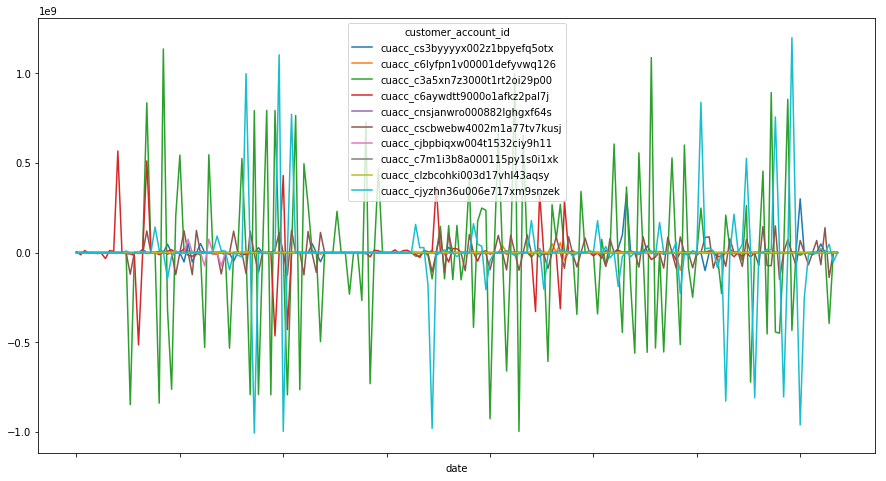

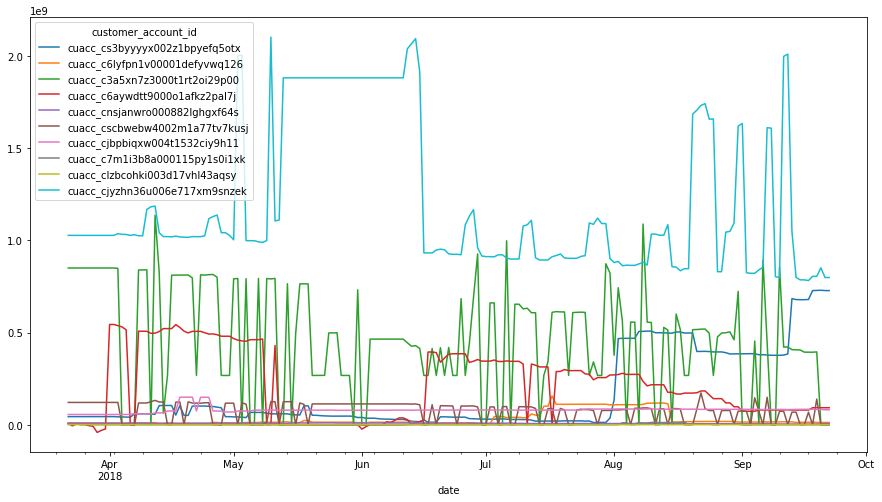

In [33]:
# Count nonzero transactions
valid_transaction_count = df_t.astype(bool).sum(axis=0).sort_values(ascending=False)

df_t.loc[: ,valid_transaction_count[:10].index].plot(figsize=(15,8))
df_b.loc[: ,valid_transaction_count[:10].index].plot(figsize=(15,8))

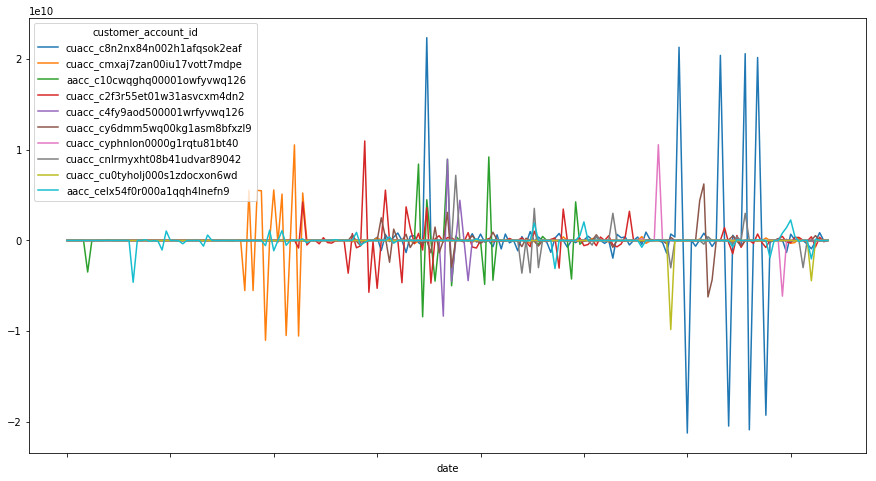

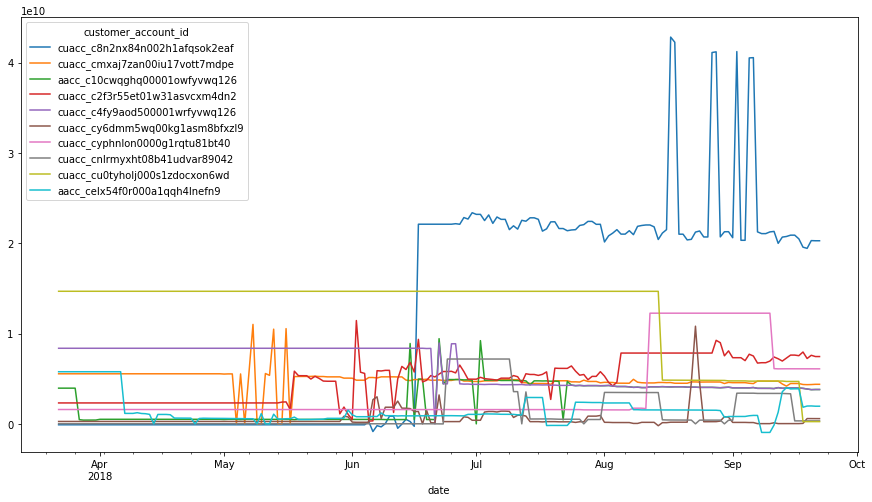

In [15]:
# Calculate transactions std
df_t_std = df_t.std().sort_values(ascending=False)

df_t.loc[: ,df_t_std[:10].index].plot(figsize=(15,8))
df_b.loc[: ,df_t_std[:10].index].plot(figsize=(15,8))

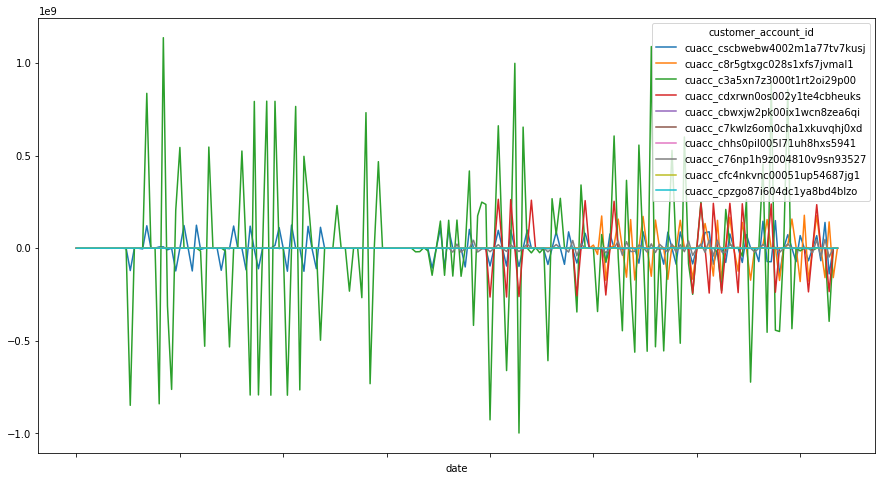

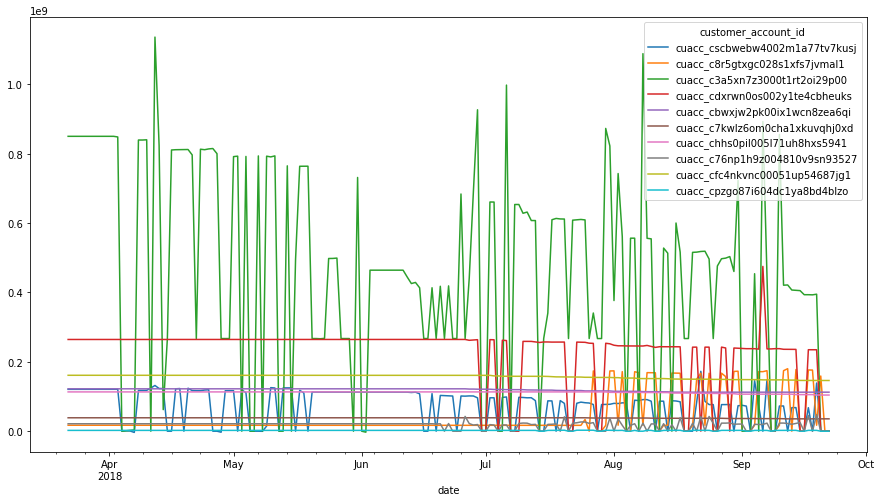

In [36]:
# Do min-max normalization
df_t_norm_std = df_t_norm.std().sort_values(ascending=False)

df_t.loc[: ,df_t_norm_std[:10].index].plot(figsize=(15,8))
df_b.loc[: ,df_t_norm_std[:10].index].plot(figsize=(15,8))

** Time Series Model **

In [40]:
valid_transaction_count[:10]
# df_t_std[:10]
# df_t_norm_std[:10]

customer_account_id
cuacc_cs3byyyyx002z1bpyefq5otx    149
cuacc_c6lyfpn1v00001defyvwq126    148
cuacc_c3a5xn7z3000t1rt2oi29p00    143
cuacc_c6aywdtt9000o1afkz2pal7j    136
cuacc_cnsjanwro000882lghgxf64s    135
cuacc_cscbwebw4002m1a77tv7kusj    133
cuacc_cjbpbiqxw004t1532ciy9h11    130
cuacc_c7m1i3b8a000115py1s0i1xk    129
cuacc_clzbcohki003d17vhl43aqsy    128
cuacc_cjyzhn36u006e717xm9snzek    127
dtype: int64

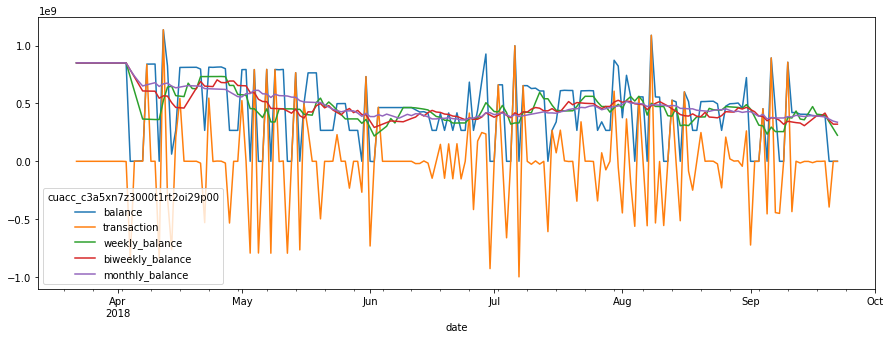

In [41]:
# Look into one specific customer
 
customer_id = "cuacc_c3a5xn7z3000t1rt2oi29p00"

cus = df_b[[customer_id]].rename(columns={customer_id: "balance"})
cus["transaction"] = df_t[customer_id]
cus.columns.name = "cuacc_c3a5xn7z3000t1rt2oi29p00"
cus["weekly_balance"] = cus.balance.rolling(window=7, min_periods=1).mean()
cus["biweekly_balance"] = cus.balance.rolling(window=14, min_periods=1).mean()
cus["monthly_balance"] = cus.balance.rolling(window=28, min_periods=1).mean()

cus.index = pd.to_datetime(cus.index)

ax = cus.plot(figsize=(15, 5))

- According to the balance line, we can find there's a Seasonality, which refers to a periodic pattern, within years, that is related to the calendar day, month, quarter etc.

- Don't see obvious Trend, which is a long run upward or downward direction in the series.


Our time series does not appear to have a trend, but it does have seasonality. When there is seasonality in a time series (which is typically the case in most real world time series) a good baseline model is a seasonal naive model.

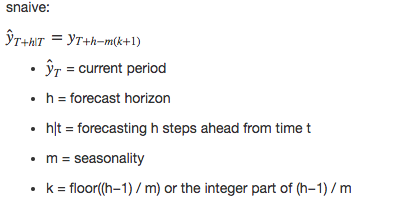



reference: https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/


### Seasonal Autoregressive Integrated Moving-Average (SARIMA)

The Seasonal Autoregressive Integrated Moving Average (SARIMA) method models the next step in the sequence as a linear function of the differenced observations, errors, differenced seasonal observations, and seasonal errors at prior time steps.

It combines the ARIMA model with the ability to perform the same autoregression, differencing, and moving average modeling at the seasonal level.